## Add some feature to the data: daily high, low and avg. for weather variables and total fires per bin.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Window size in hrs for min/max/mean
window_size = 24

# Location of raw data
input_data_file = '../training_data_pipeline/data/training_data/1992-2015_california.parquet'
output_data_file = '../training_data_pipeline/data/training_data/1992-2015_california_features_added.parquet'

#figure_directory = '../../figures/'

# Data types for read
dtypes = {
    'date_time':    'datetime64[ns]',
    'lat':          'float32',
    'lon':          'float32',
    'air_2m':       'float32',
    'apcp':         'float32',
    'crain':        'float32',
    'rhum_2m':      'float32',
    'dpt_2m':       'float32',
    'pres_sfc':     'float32',
    'uwnd_10m':     'float32',
    'vwnd_10m':     'float32',
    'veg':          'float32',
    'lcdc':         'float32',
    'hcdc':         'float32',
    'mcdc':         'float32',
    'vis':          'float32',
    'ignition':     'float32'
}

# Features to include in min/max/mean. Note: crain and veg are excluded - c rain is binary and veg is 
# not expected to change much on the timescale of days and weeks
input_features = [
    'air_2m',
    'apcp',
    'rhum_2m',
    'dpt_2m',
    'pres_sfc',
    'uwnd_10m',
    'vwnd_10m',
    'lcdc',
    'hcdc',
    'mcdc',
    'vis'
]

In [3]:
# Read data
data = pd.read_parquet(input_data_file)
data.columns = data.columns.str.replace(".", "_")
data.info()

/home/siderealyear/anaconda3/envs/wildfire_production/lib/python3.7/site-packages/fastparquet/encoding.py:222: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  Numpy8 = numba.jitclass(spec8)(NumpyIO)
/home/siderealyear/anaconda3/envs/wildfire_production/lib/python3.7/site-packages/fastparquet/encoding.py:224: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  Numpy32 = numba.jitclass(spec32)(NumpyIO)
/home/side

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752480 entries, 0 to 28752479
Data columns (total 17 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date_time  datetime64[ns]
 1   lat        float32       
 2   lon        float32       
 3   air_2m     float32       
 4   apcp       float32       
 5   crain      float32       
 6   rhum_2m    float32       
 7   dpt_2m     float32       
 8   pres_sfc   float32       
 9   uwnd_10m   float32       
 10  vwnd_10m   float32       
 11  veg        float32       
 12  lcdc       float32       
 13  hcdc       float32       
 14  mcdc       float32       
 15  vis        float32       
 16  ignition   float32       
dtypes: datetime64[ns](1), float32(16)
memory usage: 2.1 GB


### 1. Mean cloud coverage

In [4]:
# first feature to add is mean cloud cover from lcdc, mcdc and hcdc - guessing I will be unable
# to get forcasted data which is that specific. So, let's average them.
data['cloud_cover'] = data[['lcdc', 'mcdc','hcdc']].mean(axis=1)
data.drop(['lcdc', 'mcdc','hcdc'], inplace=True, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752480 entries, 0 to 28752479
Data columns (total 15 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date_time    datetime64[ns]
 1   lat          float32       
 2   lon          float32       
 3   air_2m       float32       
 4   apcp         float32       
 5   crain        float32       
 6   rhum_2m      float32       
 7   dpt_2m       float32       
 8   pres_sfc     float32       
 9   uwnd_10m     float32       
 10  vwnd_10m     float32       
 11  veg          float32       
 12  vis          float32       
 13  ignition     float32       
 14  cloud_cover  float32       
dtypes: datetime64[ns](1), float32(14)
memory usage: 1.9 GB


In [5]:
data.describe()

,lat,lon,air_2m,apcp,crain,rhum_2m,dpt_2m,pres_sfc,uwnd_10m,vwnd_10m,veg,vis,ignition,cloud_cover
count,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07,2.875248e+07
mean,3.712053e+01,-1.195196e+02,2.879437e+02,1.747614e-01,6.427751e-02,4.925317e+01,2.747225e+02,9.152788e+04,1.055434e+00,1.629087e-01,3.061381e+01,1.840885e+04,3.455034e-02,1.467838e+01
std,2.555418e+00,2.505702e+00,1.009653e+01,9.338056e-01,2.452466e-01,2.623434e+01,7.356117e+00,6.968947e+03,2.685971e+00,3.273967e+00,2.273826e+01,4.606079e+03,1.826379e-01,2.254048e+01
min,3.268389e+01,-1.243408e+02,2.465075e+02,0.000000e+00,0.000000e+00,1.000000e+00,1.921248e+02,6.624355e+04,-2.030144e+01,-2.034747e+01,0.000000e+00,3.608097e+00,0.000000e+00,0.000000e+00
25%,3.499029e+01,-1.214709e+02,2.808847e+02,0.000000e+00,0.000000e+00,2.670697e+01,2.699388e+02,8.715144e+04,-7.210264e-01,-2.033844e+00,8.200000e+00,2.000605e+04,0.000000e+00,0.000000e+00
50%,3.681598e+01,-1.198972e+02,2.869814e+02,0.000000e+00,0.000000e+00,4.562500e+01,2.752963e+02,9.232431e+04,1.048889e+00,1.210175e-01,3.050000e+01,2.000767e+04,0.000000e+00,3.000000e+00
75%,3.925970e+01,-1.174117e+02,2.946401e+02,1.939356e-03,0.000000e+00,7.139391e+01,2.801610e+02,9.708750e+04,2.732604e+00,2.273872e+00,4.360000e+01,2.001010e+04,0.000000e+00,2.100000e+01
max,4.197182e+01,-1.143645e+02,3.233755e+02,5.241433e+01,1.000000e+00,1.000312e+02,2.993494e+02,1.035852e+05,2.156606e+01,3.072835e+01,8.370000e+01,2.002581e+04,1.000000e+00,1.000000e+02


### 2. Mean, min and max for continuous weather variables

In [6]:
# Features to include in min/max/mean. Note: crain and veg are excluded - c rain is binary and veg is 
# not expected to change much on the timescale of days and weeks
input_features = [
    'date_time',
    'lat',
    'lon',
    'air_2m',
    'apcp',
    'rhum_2m',
    'dpt_2m',
    'pres_sfc',
    'uwnd_10m',
    'vwnd_10m',
    'vis',
    'cloud_cover'
]

In [7]:
# Add mean features

# Names for new columns
new_features = [
    'mean_date_time',
    'mean_lat',
    'mean_lon',
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m', 
    'mean_vwnd_10m',
    'mean_vis',
    'mean_cloud_cover'
]

# Reverse data so that the calculated value is assigned to the leading edge of
# the window with respect to time
#data_reversed = data.iloc[::-1]

# Group by location and calculate mean in rolling window over time
daily_mean = data[input_features].groupby(['lat', 'lon']).rolling(int((window_size/3)), on="date_time").mean()

# Clean up columns
daily_mean = daily_mean.droplevel(['lat', 'lon'])
daily_mean.columns = new_features
daily_mean.drop(['mean_date_time', 'mean_lat', 'mean_lon'], axis=1, inplace=True)
daily_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752480 entries, 852048 to 28101319
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   mean_air_2m       float64
 1   mean_apcp         float64
 2   mean_rhum_2m      float64
 3   mean_dpt_2m       float64
 4   mean_pres_sfc     float64
 5   mean_uwnd_10m     float64
 6   mean_vwnd_10m     float64
 7   mean_vis          float64
 8   mean_cloud_cover  float64
dtypes: float64(9)
memory usage: 2.1 GB


In [8]:
# Add max features

# Names for new columns
new_features = [
    'max_date_time',
    'max_lat',
    'max_lon',
    'max_air_2m',
    'max_apcp',
    'max_rhum_2m',
    'max_dpt_2m',
    'max_pres_sfc',
    'max_uwnd_10m', 
    'max_vwnd_10m',
    'max_vis',
    'max_cloud_cover'
]

# Reverse data so that the calculated value is assigned to the leading edge of
# the window with respect to time
#data_reversed = data.iloc[::-1]

# Group by location and calculate mean in rolling window over time
daily_max = data[input_features].groupby(['lat', 'lon']).rolling(int((window_size/3)), on="date_time").max()

# Clean up columns
daily_max = daily_max.droplevel(['lat', 'lon'])
daily_max.columns = new_features
daily_max.drop(['max_date_time', 'max_lat', 'max_lon'], axis=1, inplace=True)
daily_max.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752480 entries, 852048 to 28101319
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   max_air_2m       float64
 1   max_apcp         float64
 2   max_rhum_2m      float64
 3   max_dpt_2m       float64
 4   max_pres_sfc     float64
 5   max_uwnd_10m     float64
 6   max_vwnd_10m     float64
 7   max_vis          float64
 8   max_cloud_cover  float64
dtypes: float64(9)
memory usage: 2.1 GB


In [9]:
# Add min. features

# Names for new columns
new_features = [
    'min_date_time',
    'min_lat',
    'min_lon',
    'min_air_2m',
    'min_apcp',
    'min_rhum_2m',
    'min_dpt_2m',
    'min_pres_sfc',
    'min_uwnd_10m', 
    'min_vwnd_10m',
    'min_vis',
    'min_cloud_cover'
]

# Reverse data so that the calculated value is assigned to the leading edge of
# the window with respect to time
#data_reversed = data.iloc[::-1]

# Group by location and calculate mean in rolling window over time
daily_min = data[input_features].groupby(['lat', 'lon']).rolling(int((window_size/3)), on="date_time").min()

# Clean up columns
daily_min = daily_min.droplevel(['lat', 'lon'])
daily_min.columns = new_features
daily_min.drop(['min_date_time', 'min_lat', 'min_lon'], axis=1, inplace=True)
daily_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752480 entries, 852048 to 28101319
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   min_air_2m       float64
 1   min_apcp         float64
 2   min_rhum_2m      float64
 3   min_dpt_2m       float64
 4   min_pres_sfc     float64
 5   min_uwnd_10m     float64
 6   min_vwnd_10m     float64
 7   min_vis          float64
 8   min_cloud_cover  float64
dtypes: float64(9)
memory usage: 2.1 GB


### 3. Spread ignition over a 48 hr window including and preceding the actual fire discovery date

In [10]:
input_features = [
    'date_time',
    'lat',
    'lon',
    'ignition'
]

new_features = [
    'mean_date_time',
    'mean_lat',
    'mean_lon',
    'mean_ignition'
]

# Reverse data so that the calculated value is assigned to the leading edge of
# the window with respect to time
data_reversed = data.iloc[::-1]

# Group by location and calculate mean in rolling window over time
mean_ignition = data_reversed[input_features].groupby(['lat', 'lon']).rolling(int((window_size/3)), on="date_time").mean()

# Clean up columns
mean_ignition = mean_ignition.droplevel(['lat', 'lon'])
mean_ignition.columns = new_features
mean_ignition.drop(['mean_date_time', 'mean_lat', 'mean_lon'], axis=1, inplace=True)
mean_ignition = mean_ignition.iloc[::-1]
mean_ignition.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752480 entries, 544608 to 28407919
Data columns (total 1 columns):
 #   Column         Dtype  
---  ------         -----  
 0   mean_ignition  float64
dtypes: float64(1)
memory usage: 438.7 MB


In [11]:
joined = data.join([daily_mean, daily_max, daily_min, mean_ignition])
joined.head()

,date_time,lat,lon,air_2m,apcp,crain,rhum_2m,dpt_2m,pres_sfc,uwnd_10m,...,min_air_2m,min_apcp,min_rhum_2m,min_dpt_2m,min_pres_sfc,min_uwnd_10m,min_vwnd_10m,min_vis,min_cloud_cover,mean_ignition
0,1992-01-01 00:00:00,40.297489,-124.340797,284.818237,0.0,0.0,88.312500,282.890411,100173.562500,-1.924665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1992-01-01 03:00:00,40.297489,-124.340797,284.893280,0.0,0.0,87.739044,282.866730,100340.234375,-1.780418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1992-01-01 06:00:00,40.297489,-124.340797,284.702576,0.0,0.0,91.754997,283.325317,100361.937500,-2.190245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,1992-01-01 09:00:00,40.297489,-124.340797,284.718811,0.0,0.0,91.003128,283.237396,100463.257812,-2.539474,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,1992-01-01 12:00:00,40.297489,-124.340797,284.879425,0.0,0.0,86.509476,282.661621,100393.164062,-2.788520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [12]:
# Choose one bin at random and retrive one month worth of data
mask = (joined['date_time'] > '1997-07-01') & (joined['date_time'] <= '1997-07-31')

one_fire = joined[
    (joined['lat'] == 39.30418) &
    (joined['lon'] == -123.2773)
]

one_fire = one_fire.loc[mask]

# Sort data for plotting
one_fire = one_fire.sort_values(by='date_time',ascending=True)

# Add hour number
one_fire.insert(0, 'hour', range(1, (3 * len(one_fire)), 3))

In [13]:
one_fire.head()

,hour,date_time,lat,lon,air_2m,apcp,crain,rhum_2m,dpt_2m,pres_sfc,...,min_air_2m,min_apcp,min_rhum_2m,min_dpt_2m,min_pres_sfc,min_uwnd_10m,min_vwnd_10m,min_vis,min_cloud_cover,mean_ignition
6029049,1,1997-07-01 03:00:00,39.30418,-123.277298,288.596680,0.0,0.0,69.015686,282.872559,95630.250000,...,281.964355,0.0,51.597454,280.748047,95003.515625,-0.530106,-1.319939,10619.340820,0.0,0.0
6029050,4,1997-07-01 06:00:00,39.30418,-123.277298,283.015137,0.0,0.0,84.028931,280.412048,95600.539062,...,281.964355,0.0,51.597454,280.412048,95003.515625,-0.530106,-2.649947,10619.340820,0.0,0.0
6029051,7,1997-07-01 09:00:00,39.30418,-123.277298,282.082764,0.0,0.0,83.369156,279.391846,95659.007812,...,281.964355,0.0,51.597454,279.391846,95003.515625,-0.530106,-2.789673,16813.960938,0.0,0.0
6029052,10,1997-07-01 12:00:00,39.30418,-123.277298,281.775146,0.0,0.0,81.547455,278.762177,95627.078125,...,281.775146,0.0,51.597454,278.762177,95145.578125,-0.530106,-3.528595,20015.613281,0.0,0.0
6029053,13,1997-07-01 15:00:00,39.30418,-123.277298,287.003174,0.0,0.0,71.444748,281.887207,95312.132812,...,281.775146,0.0,51.597454,278.762177,95278.609375,0.333006,-3.758667,20015.613281,0.0,0.0


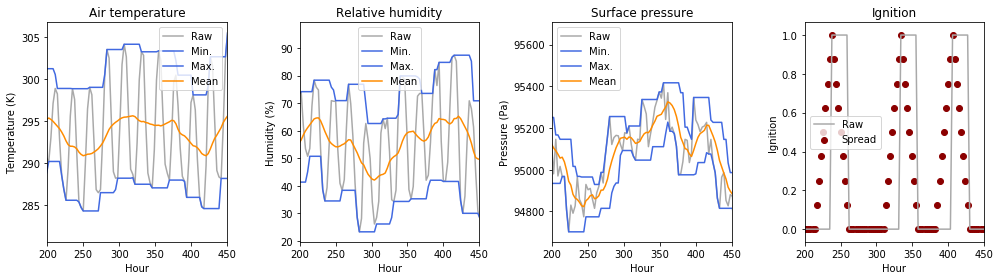

In [14]:
# Plot weather features for single fire
# xmin = min(one_fire['hour'])
# xmax = max(one_fire['hour'])
xmin = 200
xmax = 450

plt.subplots(2,2,figsize=(14,4))

plt.subplot(1, 4, 1)

plt.plot(
    one_fire['hour'], 
    one_fire['air_2m'],
    color = "darkgray",
    label ='Raw'
)
plt.plot(
    one_fire['hour'], 
    one_fire['min_air_2m'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_air_2m'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_air_2m'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Temperature (K)')
plt.title('Air temperature')
plt.legend()
plt.xlim(xmin,xmax)


plt.subplot(1, 4, 2)

plt.plot(
    one_fire['hour'], 
    one_fire['rhum_2m'],
    color = "darkgray",
    label ='Raw'
)
plt.plot(
    one_fire['hour'], 
    one_fire['min_rhum_2m'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_rhum_2m'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_rhum_2m'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Humidity (%)')
plt.title('Relative humidity')
plt.legend()
plt.xlim(xmin,xmax)


plt.subplot(1, 4, 3)

plt.plot(
    one_fire['hour'], 
    one_fire['pres_sfc'],
    color = "darkgray",
    label ='Raw'
)
plt.plot(
    one_fire['hour'], 
    one_fire['min_pres_sfc'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_pres_sfc'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_pres_sfc'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Pressure (Pa)')
plt.title('Surface pressure')
plt.legend()
plt.xlim(xmin,xmax)


plt.subplot(1, 4, 4)

plt.scatter(
    one_fire['hour'], 
    one_fire['mean_ignition'],
    color = "darkred",
    label = "Spread"
)
plt.plot(
    one_fire['hour'], 
    one_fire['ignition'],
    color = "darkgray",
    label ='Raw'
)

plt.xlabel('Hour')
plt.ylabel('Ignition')
plt.title('Ignition')
plt.legend()
plt.xlim(xmin,xmax)


plt.tight_layout()
#plt.savefig('../../figures/CA_only_min_max_mean_added.png', bbox_inches='tight')
plt.show()

**One step further - take daily average to reduce size of dataset**

In [15]:
joined['year'] = pd.DatetimeIndex(joined['date_time']).year
joined['month'] = pd.DatetimeIndex(joined['date_time']).month
joined['day'] = pd.DatetimeIndex(joined['date_time']).day

In [16]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752480 entries, 0 to 28752479
Data columns (total 46 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date_time         datetime64[ns]
 1   lat               float32       
 2   lon               float32       
 3   air_2m            float32       
 4   apcp              float32       
 5   crain             float32       
 6   rhum_2m           float32       
 7   dpt_2m            float32       
 8   pres_sfc          float32       
 9   uwnd_10m          float32       
 10  vwnd_10m          float32       
 11  veg               float32       
 12  vis               float32       
 13  ignition          float32       
 14  cloud_cover       float32       
 15  mean_air_2m       float64       
 16  mean_apcp         float64       
 17  mean_rhum_2m      float64       
 18  mean_dpt_2m       float64       
 19  mean_pres_sfc     float64       
 20  mean_uwnd_10m     float64       
 21  mean_v

In [17]:
joined = joined.groupby([
    'lat', 
    'lon', 
    'year',
    'month',
    'day'
]).mean().reset_index()

joined.loc[joined['mean_ignition'] > 0, 'mean_ignition'] = 1.0
joined.reset_index(drop=True, inplace=True)
joined.drop(['ignition'], axis=1, inplace=True)

In [18]:
joined['ignition'] = joined['mean_ignition']
joined.drop(['mean_ignition'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752480 entries, 0 to 28752479
Data columns (total 15 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date_time    datetime64[ns]
 1   lat          float32       
 2   lon          float32       
 3   air_2m       float32       
 4   apcp         float32       
 5   crain        float32       
 6   rhum_2m      float32       
 7   dpt_2m       float32       
 8   pres_sfc     float32       
 9   uwnd_10m     float32       
 10  vwnd_10m     float32       
 11  veg          float32       
 12  vis          float32       
 13  ignition     float32       
 14  cloud_cover  float32       
dtypes: datetime64[ns](1), float32(14)
memory usage: 3.2 GB


In [19]:
#date = pd.to_datetime(joined['year'], joined['month'], joined['day'])
joined['date'] = pd.to_datetime(dict(year=joined.year, month=joined.month, day=joined.day))
joined = joined.astype({'lat': 'float32', 'lon': 'float32'})

In [20]:
to_drop = [
    'year', 
    'month', 
    'day',
    'air_2m',
    'apcp',
    'rhum_2m',
    'dpt_2m',
    'pres_sfc',
    'uwnd_10m',
    'vwnd_10m',
    'vis',
    'cloud_cover'
]
joined.drop(to_drop, axis=1, inplace=True)

In [21]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 33 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   crain             float32       
 3   veg               float32       
 4   mean_air_2m       float64       
 5   mean_apcp         float64       
 6   mean_rhum_2m      float64       
 7   mean_dpt_2m       float64       
 8   mean_pres_sfc     float64       
 9   mean_uwnd_10m     float64       
 10  mean_vwnd_10m     float64       
 11  mean_vis          float64       
 12  mean_cloud_cover  float64       
 13  max_air_2m        float64       
 14  max_apcp          float64       
 15  max_rhum_2m       float64       
 16  max_dpt_2m        float64       
 17  max_pres_sfc      float64       
 18  max_uwnd_10m      float64       
 19  max_vwnd_10m      float64       
 20  max_vis           float64       
 21  max_clou

In [22]:
joined.head()

,lat,lon,crain,veg,mean_air_2m,mean_apcp,mean_rhum_2m,mean_dpt_2m,mean_pres_sfc,mean_uwnd_10m,...,min_apcp,min_rhum_2m,min_dpt_2m,min_pres_sfc,min_uwnd_10m,min_vwnd_10m,min_vis,min_cloud_cover,ignition,date
0,32.683891,-117.180901,0.000,15.6,286.606030,0.000000,74.662342,281.556606,100993.334961,-0.801620,...,0.000000,43.161045,279.903748,100793.164062,-2.931666,-2.614124,20007.591797,5.333333,0.0,1992-01-01
1,32.683891,-117.180901,0.000,15.6,286.819364,0.039405,71.860179,281.242263,100867.900635,-1.993129,...,0.000000,43.104850,279.498642,100611.048828,-3.747156,-2.614873,17882.231323,6.708333,0.0,1992-01-02
2,32.683891,-117.180901,0.125,15.6,286.278085,0.445362,78.299189,282.128052,100411.865234,-1.289372,...,0.127682,48.171734,279.066288,100169.207031,-3.350207,-1.960777,9757.630920,52.833333,0.0,1992-01-03
3,32.683891,-117.180901,0.000,15.6,286.123792,0.234453,89.555873,284.345541,100226.725098,-0.733278,...,0.021515,80.011005,283.526268,100019.046875,-1.533989,1.155087,8782.295105,15.541666,0.0,1992-01-04
4,32.683891,-117.180901,0.625,15.6,287.310151,1.329508,82.154652,284.156273,100333.872437,-0.073470,...,0.003906,70.819622,282.767273,100175.546875,-1.705194,1.410801,13555.703033,21.125000,0.0,1992-01-05


In [23]:
# Choose one bin at random and retrive one month worth of data
mask = (joined['date'] > '1997-07-01') & (joined['date'] <= '1997-07-31')

one_fire = joined[
    (joined['lat'] == 39.30418) &
    (joined['lon'] == -123.2773)
]

one_fire = one_fire.loc[mask]

# Sort data for plotting
one_fire = one_fire.sort_values(by='date',ascending=True)

# Add hour number
one_fire.insert(0, 'hour', range(1, (3 * len(one_fire)), 3))

In [24]:
one_fire.head()

,hour,lat,lon,crain,veg,mean_air_2m,mean_apcp,mean_rhum_2m,mean_dpt_2m,mean_pres_sfc,...,min_apcp,min_rhum_2m,min_dpt_2m,min_pres_sfc,min_uwnd_10m,min_vwnd_10m,min_vis,min_cloud_cover,ignition,date
2701937,1,39.30418,-123.277298,0.0,66.800003,289.250248,0.000338,65.729632,282.186540,95364.779419,...,0.0,41.791698,279.663254,95226.561523,0.784963,-6.823574,19860.423340,0.0,0.0,1997-07-02
2701938,4,39.30418,-123.277298,0.0,66.800003,293.196095,0.000755,54.801867,282.962484,95169.268799,...,0.0,34.100792,279.974060,95027.931641,0.774209,-6.307178,19884.388428,0.0,0.0,1997-07-03
2701939,7,39.30418,-123.277298,0.0,66.800003,295.037632,0.000151,52.533894,284.143243,94970.900757,...,0.0,33.685963,280.648926,94903.331055,0.999351,-5.040770,19865.434570,0.0,0.0,1997-07-04
2701940,10,39.30418,-123.277298,0.0,66.800003,293.130604,0.000669,59.244680,284.337539,94987.701294,...,0.0,39.510175,281.779541,94899.437500,1.536826,-5.341434,19812.162109,0.0,0.0,1997-07-05
2701941,13,39.30418,-123.277298,0.0,66.800003,291.892754,0.001124,63.539677,284.382756,95211.420532,...,0.0,46.541903,281.627274,95060.210938,2.185912,-6.545231,19885.144775,0.0,0.0,1997-07-06


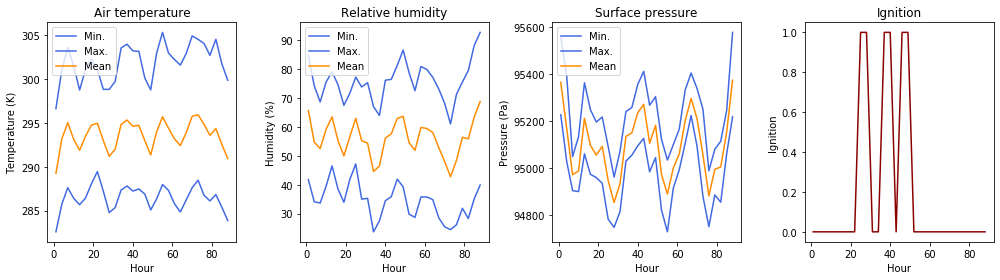

In [25]:
# Plot weather features for single fire
# xmin = min(one_fire['hour'])
# xmax = max(one_fire['hour'])
# xmin = 200
# xmax = 450

plt.subplots(2,2,figsize=(14,4))

plt.subplot(1, 4, 1)

plt.plot(
    one_fire['hour'], 
    one_fire['min_air_2m'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_air_2m'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_air_2m'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Temperature (K)')
plt.title('Air temperature')
plt.legend()
#plt.xlim(xmin,xmax)


plt.subplot(1, 4, 2)

plt.plot(
    one_fire['hour'], 
    one_fire['min_rhum_2m'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_rhum_2m'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_rhum_2m'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Humidity (%)')
plt.title('Relative humidity')
plt.legend()
#plt.xlim(xmin,xmax)


plt.subplot(1, 4, 3)

plt.plot(
    one_fire['hour'], 
    one_fire['min_pres_sfc'],
    color = "royalblue",
    label ='Min.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['max_pres_sfc'],
    color = "royalblue",
    label ='Max.'
)
plt.plot(
    one_fire['hour'], 
    one_fire['mean_pres_sfc'],
    color = "darkorange",
    label ='Mean'
)
plt.xlabel('Hour')
plt.ylabel('Pressure (Pa)')
plt.title('Surface pressure')
plt.legend()
#plt.xlim(xmin,xmax)


plt.subplot(1, 4, 4)

plt.plot(
    one_fire['hour'], 
    one_fire['ignition'],
    color = "darkred",
    label = "Spread"
)

plt.xlabel('Hour')
plt.ylabel('Ignition')
plt.title('Ignition')
#plt.xlim(xmin,xmax)


plt.tight_layout()
#plt.savefig('../../figures/CA_only_daily_mean_min_max_mean_added.png', bbox_inches='tight')
plt.show()

In [26]:
raw_percent_ignition = np.round(((len(data[data['ignition'] == 1])/len(data))*100),2)
joined_percent_ignition = np.round(((len(joined[joined['ignition'] == 1])/len(joined))*100),2)
print("Raw data is {}% ignition".format(raw_percent_ignition))
print("Processed data is {}% ignition".format(joined_percent_ignition))

Raw data is 3.46% ignition
Processed data is 6.43% ignition









**Add total fires per lat/lon bin**

In [27]:
total_fires = data[['lat', 'lon', 'ignition']].groupby(['lat', 'lon']).sum()
joined['total_fires'] = joined.apply(lambda x: total_fires.loc[(x['lat'], x['lon'])], axis=1)

In [28]:
dtypes = {
'lat':                 'float32',
'lon':                 'float32',
'mean_air_2m':         'float32',
'mean_apcp':           'float32',
'mean_rhum_2m':        'float32',
'mean_dpt_2m':         'float32',
'mean_pres_sfc':       'float32',
'mean_uwnd_10m':       'float32',
'mean_vwnd_10m':       'float32',
'mean_vis':            'float32',
'mean_cloud_cover':    'float32',
'max_air_2m':          'float32',
'max_apcp':            'float32',
'max_rhum_2m':         'float32',
'max_dpt_2m':          'float32',
'max_pres_sfc':        'float32',
'max_uwnd_10m':        'float32',
'max_vwnd_10m':        'float32',
'max_vis':             'float32',
'max_cloud_cover':     'float32',
'min_air_2m':          'float32',
'min_apcp':            'float32',
'min_rhum_2m':         'float32',
'min_dpt_2m':          'float32',
'min_pres_sfc':        'float32',
'min_uwnd_10m':        'float32',
'min_vwnd_10m':        'float32',
'min_vis':             'float32',
'min_cloud_cover':     'float32',
'ignition':            'float32',
'total_fires':         'float32',
'veg':                 'float32',
'crain':               'float32',
'date':                'datetime64[ns]'  
}

joined = joined.astype(dtypes)

In [29]:
joined.head()

,lat,lon,crain,veg,mean_air_2m,mean_apcp,mean_rhum_2m,mean_dpt_2m,mean_pres_sfc,mean_uwnd_10m,...,min_rhum_2m,min_dpt_2m,min_pres_sfc,min_uwnd_10m,min_vwnd_10m,min_vis,min_cloud_cover,ignition,date,total_fires
0,32.683891,-117.180901,0.000,15.6,286.606018,0.000000,74.662338,281.556610,100993.335938,-0.801620,...,43.161045,279.903748,100793.164062,-2.931666,-2.614124,20007.591797,5.333333,0.0,1992-01-01,1248.0
1,32.683891,-117.180901,0.000,15.6,286.819366,0.039405,71.860176,281.242249,100867.898438,-1.993129,...,43.104851,279.498657,100611.046875,-3.747156,-2.614873,17882.230469,6.708333,0.0,1992-01-02,1248.0
2,32.683891,-117.180901,0.125,15.6,286.278076,0.445362,78.299187,282.128052,100411.867188,-1.289372,...,48.171734,279.066284,100169.203125,-3.350207,-1.960777,9757.630859,52.833332,0.0,1992-01-03,1248.0
3,32.683891,-117.180901,0.000,15.6,286.123779,0.234453,89.555870,284.345551,100226.726562,-0.733278,...,80.011002,283.526276,100019.046875,-1.533989,1.155087,8782.294922,15.541666,0.0,1992-01-04,1248.0
4,32.683891,-117.180901,0.625,15.6,287.310150,1.329508,82.154648,284.156281,100333.875000,-0.073470,...,70.819626,282.767273,100175.546875,-1.705194,1.410801,13555.703125,21.125000,0.0,1992-01-05,1248.0


In [30]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 34 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   crain             float32       
 3   veg               float32       
 4   mean_air_2m       float32       
 5   mean_apcp         float32       
 6   mean_rhum_2m      float32       
 7   mean_dpt_2m       float32       
 8   mean_pres_sfc     float32       
 9   mean_uwnd_10m     float32       
 10  mean_vwnd_10m     float32       
 11  mean_vis          float32       
 12  mean_cloud_cover  float32       
 13  max_air_2m        float32       
 14  max_apcp          float32       
 15  max_rhum_2m       float32       
 16  max_dpt_2m        float32       
 17  max_pres_sfc      float32       
 18  max_uwnd_10m      float32       
 19  max_vwnd_10m      float32       
 20  max_vis           float32       
 21  max_clou

In [31]:
joined.to_parquet(output_data_file)